<a href="https://colab.research.google.com/github/kumar-abhishek/imbalanced-machine-learning-book/blob/main/chapter-7/Dynamic_sampler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# load data
test_seq = [
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(10, shear=10)] + test_seq)
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1000, shuffle=True, **kwargs)

# create imbalanced data
num_classes = 10
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)

idx_to_del = [i for i, label in enumerate(train_loader.dataset.train_labels)
              if random.random() > sample_probs[label]]
imbalanced_train_dataset = copy.deepcopy(train_dataset)
imbalanced_train_dataset.targets = np.delete(train_loader.dataset.targets, idx_to_del, axis=0)
imbalanced_train_dataset.data = np.delete(train_loader.dataset.data, idx_to_del, axis=0)
imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=64, shuffle=True, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 291960163.79it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24636097.99it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 91463107.32it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 4049857.31it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Original dataset: 60000 training samples & 10000 testing samples

Distribution of classes in original dataset:


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


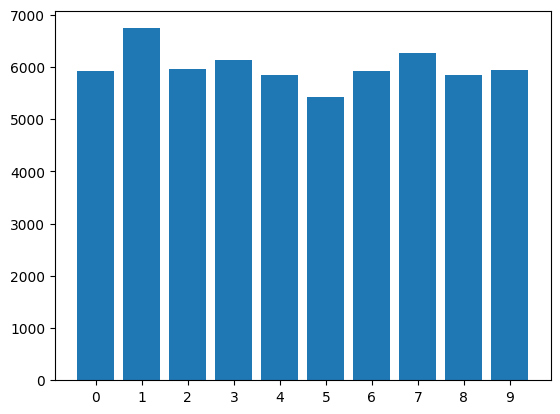

Sampling probability for each class:


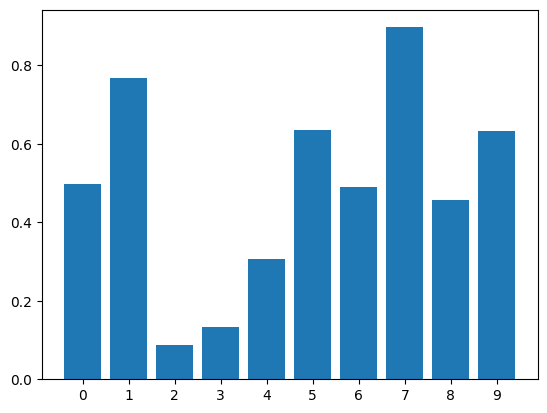

Imbalanced dataset: 29639 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


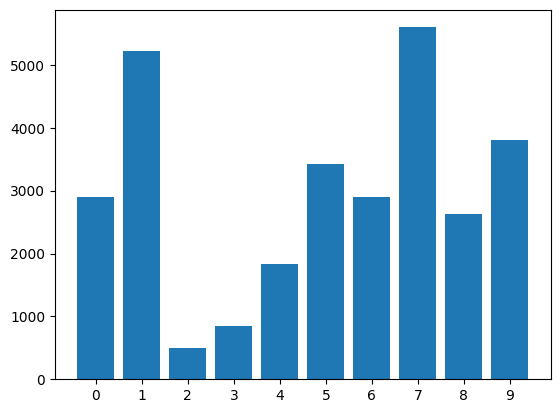

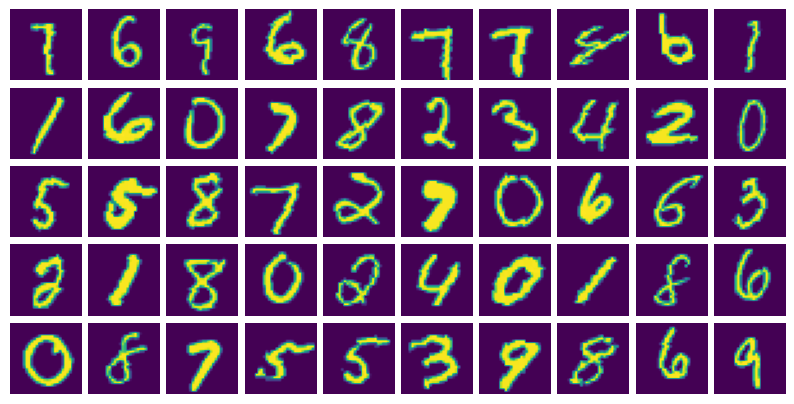

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

!pip install --quiet seaborn
import seaborn as sns

def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)

    f, a = plt.subplots(nrow, ncol, figsize=figsize)

    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis('off')

    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()

print('Original dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))

print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

print('Sampling probability for each class:')
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.show()

print('Imbalanced dataset: %d training samples & %d testing samples\n' % (
    len(imbalanced_train_loader.dataset), len(test_loader.dataset)))

print('Distribution of classes in imbalanced dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

for data, _ in train_loader:
    show_mnist(data)
    break

In [3]:
from torchvision.ops.focal_loss import sigmoid_focal_loss

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    "Focal loss implemented using F.cross_entropy"
    def __init__(self, gamma: float = 2, alpha =.98) -> None:
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = "mean"

    def forward(self, inp: torch.Tensor, target: torch.Tensor):
        loss = torch.nn.NLLLoss()
        nll_loss = loss(inp, target) # nlloss = (label=1)*log_probability = log_probability
        p_t = torch.exp(-nll_loss) # take e ^ (log_probability) = probability
        loss = (1 - p_t)**self.gamma * self.alpha * nll_loss
        return loss.mean()

##Imbalance Dataset Without Sampler

In [5]:
def vis(test_accs, confusion_mtxes, labels  ):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    return annot

def process(train_loader, test_loader, loss, epochs = 20, weight=None):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    criterion = loss()

    def train(train_loader, loss):
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx


    test_accs, confusion_mtxes = [], []
    for epoch in range(epochs):
        train(train_loader, loss)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs))

    percentages = vis(test_accs, confusion_mtxes, classe_labels)
    return percentages

In [6]:
baseline_percentages_per_class =  process(imbalanced_train_loader, test_loader, FocalLoss, epochs=50)

Best test acc = 93.73%
Best test acc = 95.75%
Best test acc = 95.75%
Best test acc = 96.59%
Best test acc = 96.59%
Best test acc = 96.93%
Best test acc = 96.93%
Best test acc = 96.93%
Best test acc = 97.06%
Best test acc = 97.06%
Best test acc = 97.06%
Best test acc = 97.15%
Best test acc = 97.25%
Best test acc = 97.56%
Best test acc = 97.56%
Best test acc = 97.63%
Best test acc = 97.63%
Best test acc = 97.91%
Best test acc = 97.91%
Best test acc = 97.91%
Best test acc = 97.91%
Best test acc = 97.91%
Best test acc = 97.92%
Best test acc = 97.92%
Best test acc = 97.92%
Best test acc = 97.92%
Best test acc = 97.92%
Best test acc = 97.92%
Best test acc = 97.92%
Best test acc = 97.92%
Best test acc = 97.92%
Best test acc = 97.92%
Best test acc = 97.92%
Best test acc = 98.00%
Best test acc = 98.00%
Best test acc = 98.00%
Best test acc = 98.00%
Best test acc = 98.00%
Best test acc = 98.13%
Best test acc = 98.13%
Best test acc = 98.13%
Best test acc = 98.13%
Best test acc = 98.13%
Best test a

# WeightedRandomSampler - PyTorch

In [7]:
class_counts = pd.Series(imbalanced_train_loader.dataset.targets.numpy())	.value_counts()
class_weights = 1.0/class_counts

In [8]:
from torch.utils.data import WeightedRandomSampler
weightedRandomSampler = WeightedRandomSampler(weights=class_weights, num_samples=len(imbalanced_train_dataset), replacement=True)
weightedRandomSampler_dataloader = torch.utils.data.DataLoader(imbalanced_train_loader, sampler=weightedRandomSampler, batch_size=64)


In [9]:
weightedRandomSampler_percentages_per_class =  process(imbalanced_train_loader, test_loader, FocalLoss, epochs=50)

Best test acc = 68.07%
Best test acc = 95.41%
Best test acc = 95.53%
Best test acc = 97.08%
Best test acc = 97.08%
Best test acc = 97.08%
Best test acc = 97.08%
Best test acc = 97.25%
Best test acc = 97.62%
Best test acc = 97.70%
Best test acc = 97.70%
Best test acc = 97.70%
Best test acc = 97.80%
Best test acc = 97.86%
Best test acc = 97.86%
Best test acc = 97.86%
Best test acc = 97.86%
Best test acc = 97.86%
Best test acc = 98.13%
Best test acc = 98.13%
Best test acc = 98.13%
Best test acc = 98.17%
Best test acc = 98.24%
Best test acc = 98.24%
Best test acc = 98.24%
Best test acc = 98.24%
Best test acc = 98.24%
Best test acc = 98.24%
Best test acc = 98.24%
Best test acc = 98.24%
Best test acc = 98.24%
Best test acc = 98.24%
Best test acc = 98.24%
Best test acc = 98.30%
Best test acc = 98.30%
Best test acc = 98.30%
Best test acc = 98.30%
Best test acc = 98.30%
Best test acc = 98.30%
Best test acc = 98.30%
Best test acc = 98.30%
Best test acc = 98.30%
Best test acc = 98.30%
Best test a

##Dynamic Sampling

In [10]:
# define a custom sampler
class DynamicSampler(torch.utils.data.sampler.Sampler):
    """Samples elements from a given list of indices with given probabilities (weights), with replacement.

    Arguments:
        weights (sequence)   : a sequence of weights, not necessary summing up to one
        num_samples (int): number of samples to draw
    """

    def __init__(self, indices, weights, num_samples=0):
        if  isinstance(num_samples, bool):
            raise ValueError("num_samples should be a non-negative integeral "
                             "value, but got num_samples={}".format(num_samples))
        self.indices = indices
        weights = [ weights[i] for i in self.indices ]
        self.weights = torch.tensor(weights, dtype=torch.double)
        if num_samples == 0:
            self.num_samples = len(self.weights)
        else:
            self.num_samples = num_samples
        self.replacement = True

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, self.replacement))

    def __len__(self):
        return self.num_samples

In [11]:
from sklearn.metrics import confusion_matrix

def create_model():
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    return model, optimizer

def train_model(model, optimizer, train_loader, loss_criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate_model(model, test_loader):
    model.eval()
    correct_predictions = 0
    targets = []
    outputs = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct_predictions += pred.eq(target.view_as(pred)).sum().item()
            outputs.append(pred)
            targets.append(target)
    return correct_predictions, outputs, targets

def calculate_metrics(outputs, targets):
    outputs = torch.cat(outputs,0).detach().cpu().numpy()
    targets = torch.cat(targets,0).detach().cpu().numpy()
    cf = confusion_matrix(outputs, targets, labels=np.array(range(10)))

    precision = np.array([])
    recall = np.array([])
    for i in range(len(cf)):
        if np.sum(cf[i]) == 0:
            precision = np.append(precision, 1)
        else:
            precision = np.append(precision, cf[i][i] / np.sum(cf[i]))
        if np.sum(cf, axis=0)[i] == 0:
            recall = np.append(recall, 0)
        else:
            recall = np.append(recall, cf[i][i] / np.sum(cf, axis=0)[i])
    return precision, recall, cf

def calculate_weights(precision, recall, cf):
    f1_scores = np.zeros((len(cf)))
    for i in range(len(cf)):
        if precision[i]+recall[i] == 0:
            f1_scores[i] = 0
        else:
            f1_scores[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])

    weights = (1-f1_scores)*10/ (1-f1_scores).sum()
    return weights

def process_sampler(train_dataset, test_dataset, loss, epochs = 20):
    model, optimizer = create_model()
    loss_criterion = loss()

    test_accs, confusion_mtxes = [], []
    samples_weights = np.ones(len(train_dataset.targets))
    train_target_indexes = np.arange(0, len(train_dataset.targets), 1, dtype=int)
    for epoch in range(epochs):
        train_sampler = DynamicSampler(train_target_indexes, samples_weights)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler, num_workers=0)

        train_model(model, optimizer, train_loader, loss_criterion)

        correct_predictions, outputs, targets = evaluate_model(model, test_loader)
        test_acc = 100. * correct_predictions / len(test_loader.dataset)
        test_accs.append(test_acc)

        precision, recall, confusion_mtx = calculate_metrics(outputs, targets)
        confusion_mtxes.append(confusion_mtx)

        weights = calculate_weights(precision, recall, confusion_mtx)

        for i in range (0, len(samples_weights)):
            samples_weights[i] = weights[train_dataset.targets[i]]

        print('\rBest test acc = %2.2f%%' % max(test_accs))

    percentages = vis(test_accs, confusion_mtxes, classe_labels)
    return percentages


In [12]:
dynamic_sampling_percentages_per_class = process_sampler(imbalanced_train_dataset, test_loader, FocalLoss, epochs=50)

Best test acc = 89.28%
Best test acc = 95.91%
Best test acc = 96.03%
Best test acc = 97.00%
Best test acc = 97.10%
Best test acc = 97.10%
Best test acc = 97.41%
Best test acc = 97.41%
Best test acc = 97.49%
Best test acc = 97.49%
Best test acc = 97.49%
Best test acc = 97.49%
Best test acc = 97.49%
Best test acc = 97.59%
Best test acc = 97.63%
Best test acc = 97.77%
Best test acc = 97.77%
Best test acc = 97.77%
Best test acc = 97.77%
Best test acc = 97.77%
Best test acc = 98.00%
Best test acc = 98.00%
Best test acc = 98.04%
Best test acc = 98.04%
Best test acc = 98.04%
Best test acc = 98.06%
Best test acc = 98.06%
Best test acc = 98.06%
Best test acc = 98.06%
Best test acc = 98.09%
Best test acc = 98.09%
Best test acc = 98.09%
Best test acc = 98.09%
Best test acc = 98.11%
Best test acc = 98.19%
Best test acc = 98.19%
Best test acc = 98.22%
Best test acc = 98.22%
Best test acc = 98.40%
Best test acc = 98.40%
Best test acc = 98.40%
Best test acc = 98.40%
Best test acc = 98.40%
Best test a

# Baseline vs WeightedRandomSampler vs dynamic sampling

In [13]:
import pandas as pd

print('Baseline model: ', np.diagonal(baseline_percentages_per_class))
print('WeightedRandomSampler: ', np.diagonal(weightedRandomSampler_percentages_per_class))
print('Dynamic Sampling: ', np.diagonal(dynamic_sampling_percentages_per_class))

classes = np.arange(10)
list1 = np.diagonal(baseline_percentages_per_class)
list2 = np.diagonal(weightedRandomSampler_percentages_per_class)
list3 = np.diagonal(dynamic_sampling_percentages_per_class)

df = pd.DataFrame({
    "Baseline model": list1,
    "WeightedRandomSampler": list2,
    "Dynamic Sampler": list3,
})
print(df)

Baseline model:  ['99.5%' '99.6%' '93.5%' '97.6%' '99.1%' '99.0%' '99.0%' '99.2%' '97.5%'
 '97.3%']
WeightedRandomSampler:  ['99.1%' '99.4%' '96.1%' '97.6%' '98.4%' '99.1%' '99.1%' '99.0%' '98.7%'
 '98.1%']
Dynamic Sampling:  ['97.7%' '99.4%' '99.1%' '99.5%' '99.1%' '97.9%' '99.1%' '94.5%' '99.5%'
 '98.6%']
  Baseline model WeightedRandomSampler Dynamic Sampler
0          99.5%                 99.1%           97.7%
1          99.6%                 99.4%           99.4%
2          93.5%                 96.1%           99.1%
3          97.6%                 97.6%           99.5%
4          99.1%                 98.4%           99.1%
5          99.0%                 99.1%           97.9%
6          99.0%                 99.1%           99.1%
7          99.2%                 99.0%           94.5%
8          97.5%                 98.7%           99.5%
9          97.3%                 98.1%           98.6%
